In [1]:
import datetime as dt
import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
import APSIMOptimiserTools as OT
import MathsUtilities as MUte
import shlex # package to construct the git command to subprocess format
import subprocess 
import xmltodict, json
import sqlite3
import scipy.optimize 
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver
from skopt import load
from skopt.plots import plot_objective

In [2]:
SimSet = OT.makeLongString(["Lincoln2014IrrigFull",
                            "Lincoln2014IrrigVeryEarly",
                            "Lincoln2014IrrigEarly",
                            "Lincoln1992Sow5MayIrrSomeNit3",
                            "Lincoln9192Irrig01",
                            "APS26NRate160,WaterWet",
                            "APS6NRate360",
                            "GattonrowSpacingRowSpace25cm",
                            "GattonrowSpacingRowSpace50cm",
                            "YarrabahCreek",
                            "ArizonaFACE92",
                            "ArizonaFACE93",
                            "Yucheng02",
                            "Yucheng03",
                            "Yucheng04"])

paramNames = ['[Leaf].Canopy.GreenAreaIndex.SenescenceStresses.ShadingEffect.XYPairs.X[2]',
              '[Leaf].Canopy.GreenAreaIndex.SenescenceStresses.ShadingEffect.XYPairs.X[3]',
              '[Leaf].Canopy.GreenAreaIndex.SenescenceStresses.ShadingEffect.XYPairs.X[4]',
              '[Leaf].SenescenceRate.Vegetative.Total.TillerDeath.RelativeSizeOfDyingTillers.FixedValue', 
              '[Leaf].SenescenceRate.Vegetative.Total.LeafDeath.MaxRate.FixedValue',
              '[Wheat].StemNumber.DeadTillers.Attrition.MaxRate.FixedValue',
              '[Wheat].TilleringRate.Vegetative.StressedRate.Stresses.CoverEffect.XYPairs.X[2]',
              '[Wheat].TilleringRate.Vegetative.StressedRate.Stresses.CoverEffect.XYPairs.X[3]']

paramAliases = ['ShadeSen0',
                'ShadeSen50',
                'ShadeSen100',
                'RelSizeDyingTillers',
                'MaxLeafSenRate',
                'MaxTillerAttRate',
                'ShadeTillerStop100',
                'ShadeTillerStop0']

def ConstrainParams(paramValues):
    paramValues[1] = paramValues[0] + (1-paramValues[0]) * paramValues[1]
    paramValues[2] = paramValues[1] + (1-paramValues[1]) * paramValues[2]
    paramValues[7] = paramValues[6] + 0.3 * paramValues[7]
    return paramValues

FittingVariables = ['Wheat.Leaf.Canopy.LAI','Wheat.Leaf.Live.Wt', 'Wheat.StemPopulation']

Path = r"C:\GitHubRepos\ApsimX\Tests\Validation\Wheat"
APSIMXfilePath = Path + r"\Wheat.apsimx"
DBfilePath = Path + r"\Wheat.db" 
FittingResultsFileName = "LeafSenParams.pkl"
RandomCalls = 300
OptimizerCalls = 30
TotalCalls = RandomCalls + OptimizerCalls
x0 = [0.35820730426965586, 0.7283164499964966, 0.8193844506508974, 0.45778463290242033, 0.008247110271844011, 0.015410302318122144, 0.15,0.25]
bounds = [(0.2,0.95),
          (0.0,1.0),
          (0.0,1.0),
          (0.25,1.0),
          (0.001,0.03),
          (0.001,0.03),
          (0.1,0.5),
          (0.0,1.0)]

OT.AddBlankSetCropParams(APSIMXfilePath)

In [3]:
#this function applies parameter set to apsim, runs selected simulatoins and returns results
def runModelItter(paramValues,paramNames,FilePath):
    OT.ApplyParamReplacementSet(paramValues,paramNames,FilePath)
    subprocess.run(['C:/GitHubRepos/ApsimX/bin/Debug/net6.0/Models.exe',
                FilePath,
                SimSet], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    con = sqlite3.connect(DBfilePath)
    ObsPred = pd.read_sql("Select * from DailyObsPred",con)
    con.close()
    return ObsPred

# The below calculations turn parameters 1 and 2 into absoloute values from the relative values the optimiser passes
def paramTransformations(paramValues):
    paramValues[1] = paramValues[0] + (1-paramValues[0]) * paramValues[1] 
    paramValues[2] = paramValues[1] + (1-paramValues[1]) * paramValues[2]
    paramValues[7] = paramValues[6] + 0.3 * paramValues[7]
    return paramValues

#this is the function that the optimiser calls
def runFittingItter(paramValues):
    start = dt.datetime.now() #set start time
    !del C:\GitHubRepos\ApsimX\Tests\Validation\Wheat\Wheat.db #delete .db file so we are sure to get clean results
    
    paramValues = paramTransformations(paramValues)
    
    ObsPred = runModelItter(paramValues,paramNames,APSIMXfilePath) #Get model results with current parameter set
    
    endrun = dt.datetime.now() #set end time
    runtime = (endrun-start).seconds #calculate run duration
    n = len(ObsPred.loc[:,'Predicted.Simulation.Name'].drop_duplicates())  #Calculate how many simulations ran
    
    ScObsPre = pd.DataFrame(columns = ['ScObs','ScPred','Var','Predicted.Simulation.Name','Predicted.Experiment','Predicted.Wheat.SowingDate'])
    indloc = 0
    for var in FittingVariables:
        DataPairs = ObsPred.reindex(['Observed.'+var,'Predicted.'+var,'Predicted.Simulation.Name','Predicted.Experiment','Predicted.Wheat.SowingDate'],axis=1).dropna()
        for v in ['Observed.'+var,'Predicted.'+var]:
            DataPairs.loc[:,v] = pd.to_numeric(DataPairs.loc[:,v])
        VarMax = max(DataPairs.loc[:,'Observed.'+var].max(),DataPairs.loc[:,'Predicted.'+var].max())
        VarMin = min(DataPairs.loc[:,'Observed.'+var].min(),DataPairs.loc[:,'Predicted.'+var].min())
        for x in DataPairs.index:
            ScObsPre.loc[indloc,'ScObs'] = OT.CalcScaledValue(DataPairs.loc[x,'Observed.'+var],VarMax,VarMin)
            ScObsPre.loc[indloc,'ScPred'] = OT.CalcScaledValue(DataPairs.loc[x,'Predicted.'+var],VarMax,VarMin)
            ScObsPre.loc[indloc,'Var'] = var
            globals()['IttersObsPred'].loc[(globals()['itter'],indloc),['ScObs','ScPred','Var']] = ScObsPre.loc[indloc,['ScObs','ScPred','Var']]
            globals()['IttersObsPred'].loc[(globals()['itter'],indloc),
                                          ['Predicted.Simulation.Name','Predicted.Experiment','Predicted.Wheat.SowingDate']] = DataPairs.loc[x,['Predicted.Simulation.Name','Predicted.Experiment','Predicted.Wheat.SowingDate']]
            indloc+=1
    RegStats = MUte.MathUtilities.CalcRegressionStats('LN',ScObsPre.loc[:,'ScPred'].values,ScObsPre.loc[:,'ScObs'].values)
    # globals()['IttersObsPred'].loc[(globals()['itter'],'All'),['NSE','nSims']] = [RegStats.NSE,n]
    # globals()['IttersObsPred'].loc[(globals()['itter'],'All'),paramNames] = paramValues
    try:
        retVal = RegStats.NSE *-1
        print(str(globals()['itter']) +"  "+ str(paramValues) + " run completed " +str(n) + ' sims in '+ str(runtime) + ' seconds.  NSE = '+str(RegStats.NSE))
    except:
        retVal = 4
        print(str(globals()['itter']) +"  "+ str(paramValues) + " run completed " +str(n) + ' sims in '+ str(runtime) + ' seconds.  NSE = insufficient data')
    globals()['IttersObsPred'].to_pickle("./OptFiles/IttersObsPred"+FittingResultsFileName)
    globals()['itter'] +=1
    return retVal

In [ ]:
#this cell runs the optimisation.
globals()['itter'] = 0
IttersObsPred = pd.DataFrame(columns = ['ScObs','ScPred','Var','Predicted.Simulation.Name','Predicted.Experiment','Predicted.Wheat.SowingDate',
                                                       'NSE','nSims']+paramNames,
                                                        index=pd.MultiIndex.from_arrays([[],[]],names=['itter','indloc']))

checkpoint_saver = CheckpointSaver("./OptFiles/"+FittingResultsFileName, compress=9)

ret = gp_minimize(runFittingItter, bounds, n_calls=TotalCalls,n_initial_points=RandomCalls,
         initial_point_generator='sobol',callback=[checkpoint_saver],x0=x0)

C:\Users\Cflhxb\AppData\Local\anaconda3\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+301=301. 
  warnings.warn("The balance properties of Sobol' points require "


0  [0.35820730426965586, 0.8256354820576618, 0.9685070568048532, 0.45778463290242033, 0.008247110271844011, 0.015410302318122144, 0.15, 0.22499999999999998] run completed 14 sims in 21 seconds.  NSE = 0.318725296145981
1  [0.22798831060444874, 0.4259600279177189, 0.5479599300500201, 0.4087598423368672, 0.02449729089561015, 0.01183137928144326, 0.17965288678566643, 0.38989451935787667] run completed 14 sims in 24 seconds.  NSE = -0.3779812241376521
2  [0.41548831060444874, 0.4192503245464464, 0.687863649295259, 0.9712598423368672, 0.0027472908956101506, 0.004581379281443263, 0.27965288678566647, 0.4148945193578767] run completed 14 sims in 25 seconds.  NSE = -1.6191976155631629
3  [0.7904883106044489, 0.8965926071994528, 0.9961251785139801, 0.5962598423368672, 0.01724729089561015, 0.019081379281443264, 0.4796528867856664, 0.7648945193578767] run completed 14 sims in 24 seconds.  NSE = 0.09548156629053317
4  [0.8842383106044489, 0.8994535831649287, 0.9333908728140928, 0.8775098423368672,

In [5]:
#This cell only needs to be run if wanting to generte graphs without running optimiser.  
#i.e using results from previous optimisation attempt
IttersObsPred = pd.read_pickle("./OptFiles/IttersObsPred"+ FittingResultsFileName)
ret = load("./OptFiles/"+FittingResultsFileName)

In [6]:
#Display best fit parameter values
paramTransformations(ret.x)

[0.5912695606044487,
 0.8470662645885193,
 0.986232383342906,
 0.3267285923368672,
 0.006825415895610151,
 0.021347004281443264,
 0.21090288678566643,
 0.30208999259302943]

In [7]:
#Show best fit parameter values
pd.Series(index=paramNames,data=paramTransformations(ret.x))

[Leaf].Canopy.GreenAreaIndex.SenescenceStresses.ShadingEffect.XYPairs.X[2]                  0.591270
[Leaf].Canopy.GreenAreaIndex.SenescenceStresses.ShadingEffect.XYPairs.X[3]                  0.937491
[Leaf].Canopy.GreenAreaIndex.SenescenceStresses.ShadingEffect.XYPairs.X[4]                  0.999139
[Leaf].SenescenceRate.Vegetative.Total.TillerDeath.RelativeSizeOfDyingTillers.FixedValue    0.326729
[Leaf].SenescenceRate.Vegetative.Total.LeafDeath.MaxRate.FixedValue                         0.006825
[Wheat].StemNumber.DeadTillers.Attrition.MaxRate.FixedValue                                 0.021347
[Wheat].TilleringRate.Vegetative.StressedRate.Stresses.CoverEffect.XYPairs.X[2]             0.210903
[Wheat].TilleringRate.Vegetative.StressedRate.Stresses.CoverEffect.XYPairs.X[3]             0.301530
dtype: float64

In [8]:
runModelItter(paramTransformations(ret.x),paramNames,APSIMXfilePath)

,CheckpointID,SimulationID,Observed.Experiment,Predicted.Experiment,Clock.Today,Observed.Wheat.SowingDate,Predicted.Wheat.SowingDate,Observed.Simulation.Name,Predicted.Simulation.Name,Observed.Soil.Water.Volumetric(1),...,Predicted.Wheat.Stem.Wt,Pred-Obs.Wheat.Stem.Wt,Observed.Wheat.SowingData.Population,Predicted.Wheat.SowingData.Population,Pred-Obs.Wheat.SowingData.Population,Observed.ET,Predicted.ET,Pred-Obs.ET,Observed.Wheat.SowingData.Cultivar,Predicted.Wheat.SowingData.Cultivar
0,1,1,None,APS6,1992-07-12 12:00:00,None,1992-06-17 12:00:00,APS6NRate360,APS6NRate360,NaN,...,0.392019,-1.807981,NaN,121.61,NaN,NaN,0.825599,NaN,None,Hartog
1,1,1,None,APS6,1992-07-13 12:00:00,None,1992-06-17 12:00:00,APS6NRate360,APS6NRate360,NaN,...,0.481569,NaN,NaN,121.61,NaN,NaN,0.791736,NaN,None,Hartog
2,1,1,None,APS6,1992-07-27 12:00:00,None,1992-06-17 12:00:00,APS6NRate360,APS6NRate360,NaN,...,2.646853,-19.353147,NaN,121.61,NaN,NaN,1.371783,NaN,None,Hartog
3,1,1,None,APS6,1992-07-28 12:00:00,None,1992-06-17 12:00:00,APS6NRate360,APS6NRate360,NaN,...,3.020703,NaN,NaN,121.61,NaN,NaN,3.285943,NaN,None,Hartog
4,1,1,None,APS6,1992-08-24 12:00:00,None,1992-06-17 12:00:00,APS6NRate360,APS6NRate360,NaN,...,136.540001,-76.159999,NaN,121.61,NaN,NaN,4.850636,NaN,None,Hartog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,1,18,None,None,2005-05-30 12:00:00,None,2004-10-14 12:00:00,Yucheng04,Yucheng04,NaN,...,224.646981,NaN,NaN,100.00,NaN,NaN,1.553319,NaN,None,Keyu13
666,1,18,None,None,2005-05-31 12:00:00,None,2004-10-14 12:00:00,Yucheng04,Yucheng04,NaN,...,224.646981,NaN,NaN,100.00,NaN,NaN,1.487570,NaN,None,Keyu13
667,1,18,None,None,2005-06-05 12:00:00,None,2004-10-14 12:00:00,Yucheng04,Yucheng04,NaN,...,224.646981,NaN,NaN,100.00,NaN,NaN,1.189704,NaN,None,Keyu13
668,1,18,None,None,2005-06-07 12:00:00,None,2004-10-14 12:00:00,Yucheng04,Yucheng04,NaN,...,224.646981,NaN,NaN,100.00,NaN,NaN,1.090086,NaN,None,Keyu13


No acceptable fits


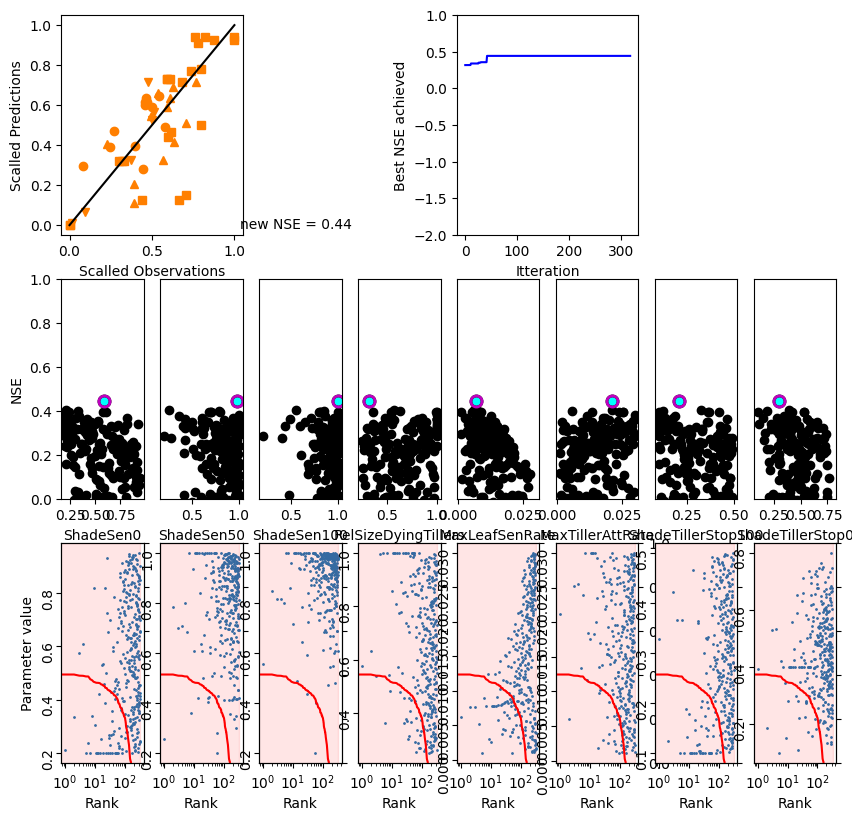

In [9]:
## this cell makes some useful graphs
ShortParams = pd.Series(index=paramNames,data=paramAliases)
ParamCombs = pd.DataFrame(ret.x_iters,columns = paramNames)
ParamCombs.loc[:,'NSE'] = ret.func_vals
bestFit = ParamCombs.loc[:,'NSE'].idxmin()
ParamCombs.sort_values('NSE',inplace=True)
ParamCombs.loc[:,'Rank'] = range(len(ParamCombs.index))
#adequateFits = min(sum(ParamCombs.NSE.values<-0.5),sum(ParamCombs.NSE.values<ParamCombs.loc[bestFit,'NSE']*.8))
ParamCombs.sort_index(inplace=True)
bestFitItter = ParamCombs.loc[:,'NSE'].idxmin()
bestFitObsPred = IttersObsPred.loc[bestFitItter,:]
OT.PlotResults(bestFitObsPred,ret,ParamCombs,FittingVariables,ShortParams)

In [ ]:
plot_objective(ret)

In [ ]:
ret

In [10]:
#this method strips the SetCropParam managers out of the .apsimx file.  
#For some reason it only works if the file is opened in the gui between running the optimisation
#and running this function
OT.RemoveBlankSetCropParams(APSIMXfilePath)